<a href="https://colab.research.google.com/github/sourcecode369/unconventional-neural-networks/blob/master/Black_and_White_Image_Colorization_using_Autoencoders_and_InceptionResnetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhtsingh","key":"694681130c8b848aaca6d1d52f6b594d"}'}

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 5.3MB 8.4MB/s 
     |████████████████████████████████| 112kB 61.1MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 112kB 64.8MB/s 


In [4]:
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets list

ref                                                      title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
rajeevw/ufcdata                                          UFC-Fight historical data from 1993 to 2019          3MB  2019-07-05 09:58:02          10192  
gustavomodelli/forest-fires-in-brazil                    Forest Fires in Brazil                              31KB  2019-08-24 16:09:16          15580  
akhilv11/border-crossing-entry-data                      Border Crossing Entry Data                           4MB  2019-08-21 14:51:34           6474  
tristan581/17k-apple-app-store-strategy-games            17K Mobile Strategy Games                            8MB  2019-08-26 08:22:16          12999  
chirin/africa-economic-banking-and-systemic-crisis-data  Africa Economic, Banking and Sy

In [6]:
!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving
!kaggle datasets download -d valkling/inception-resnet-v2-weights

 99% 577M/583M [00:14<00:00, 35.0MB/s]
100% 583M/583M [00:14<00:00, 41.3MB/s]
 95% 188M/199M [00:04<00:00, 35.1MB/s]
100% 199M/199M [00:04<00:00, 49.0MB/s]


In [1]:
import os
import sys
import random
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='skimage')

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from PIL import Image
from tqdm import tqdm
from itertools import chain 
from IPython.display import clear_output, display 

import skimage
from skimage.io import (imread, 
                        imshow, 
                        imread_collection, 
                        concatenate_images)
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label 
from skimage.color import (rgb2gray, 
                           gray2rgb, 
                           rgb2lab, 
                           lab2rgb)

from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import (InceptionResNetV2, 
                                                    preprocess_input, 
                                                    decode_predictions)
from keras.layers import (Input, Dense, 
                          UpSampling2D, 
                          RepeatVector, 
                          Reshape, Conv2D, 
                          Conv2DTranspose, 
                          MaxPool2D, 
                          MaxPooling2D, 
                          Dropout, Lambda)
from keras.models import (Model, 
                          Sequential, 
                          load_model)
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import (ModelCheckpoint, 
                             EarlyStopping, 
                             ReduceLROnPlateau, 
                             LearningRateScheduler)
from keras import backend as K
import tensorflow as tf
np.random.seed(2019)
random.seed(2019)

Using TensorFlow backend.


In [8]:
!ls -GFlash --color

total 782M
4.0K drwxr-xr-x 1 root 4.0K Nov 25 16:57 ./
4.0K drwxr-xr-x 1 root 4.0K Nov 25 16:53 ../
583M -rw-r--r-- 1 root 583M Nov 25 16:57 art-images-drawings-painting-sculpture-engraving.zip
4.0K drwxr-xr-x 1 root 4.0K Nov 21 16:30 .config/
199M -rw-r--r-- 1 root 199M Nov 25 16:57 inception-resnet-v2-weights.zip
4.0K drwxr-xr-x 1 root 4.0K Nov 21 16:30 sample_data/


In [0]:
import zipfile
with zipfile.ZipFile('art-images-drawings-painting-sculpture-engraving.zip', 'r') as zip_ref:
    zip_ref.extractall('art-images-drawings-painting-sculpture-engraving')

with zipfile.ZipFile('inception-resnet-v2-weights.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [10]:
!ls 

art-images-drawings-painting-sculpture-engraving
art-images-drawings-painting-sculpture-engraving.zip
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception-resnet-v2-weights.zip
sample_data


### Read in data

In [55]:
for _, __, filename in os.walk('art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated/training_set/'):
  if len(filename)==2128:
    print(len(filename),":",filename[:10], "...")

2128 : ['1777.jpg', '0182.jpg', '1316.jpg', '0888.jpg', '0880.jpg', '0531.jpg', '0997.jpg', '0850.jpg', '0323.jpg', '0239.jpg'] ...


In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated/training_set/painting/'
train_ids = next(os.walk(TRAIN_PATH))[2]

In [11]:
%%time
# (Note that 86 of the train_ids have errors while being loading into our dataset, so we will just skip over them. We don't really need them.)

X_train = np.zeros((len(train_ids)-86, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print("Getting train images..")
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_ + ''
  try:
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n-missing_count] = img
  except:
    missing_count += 1

X_train = X_train.astype('float32') / 255.
print('Total missing: {}'.format(missing_count))

Getting train images..


100%|██████████| 2128/2128 [00:36<00:00, 59.09it/s]


Total missing: 86
CPU times: user 39.6 s, sys: 30.3 s, total: 1min 9s
Wall time: 37.4 s


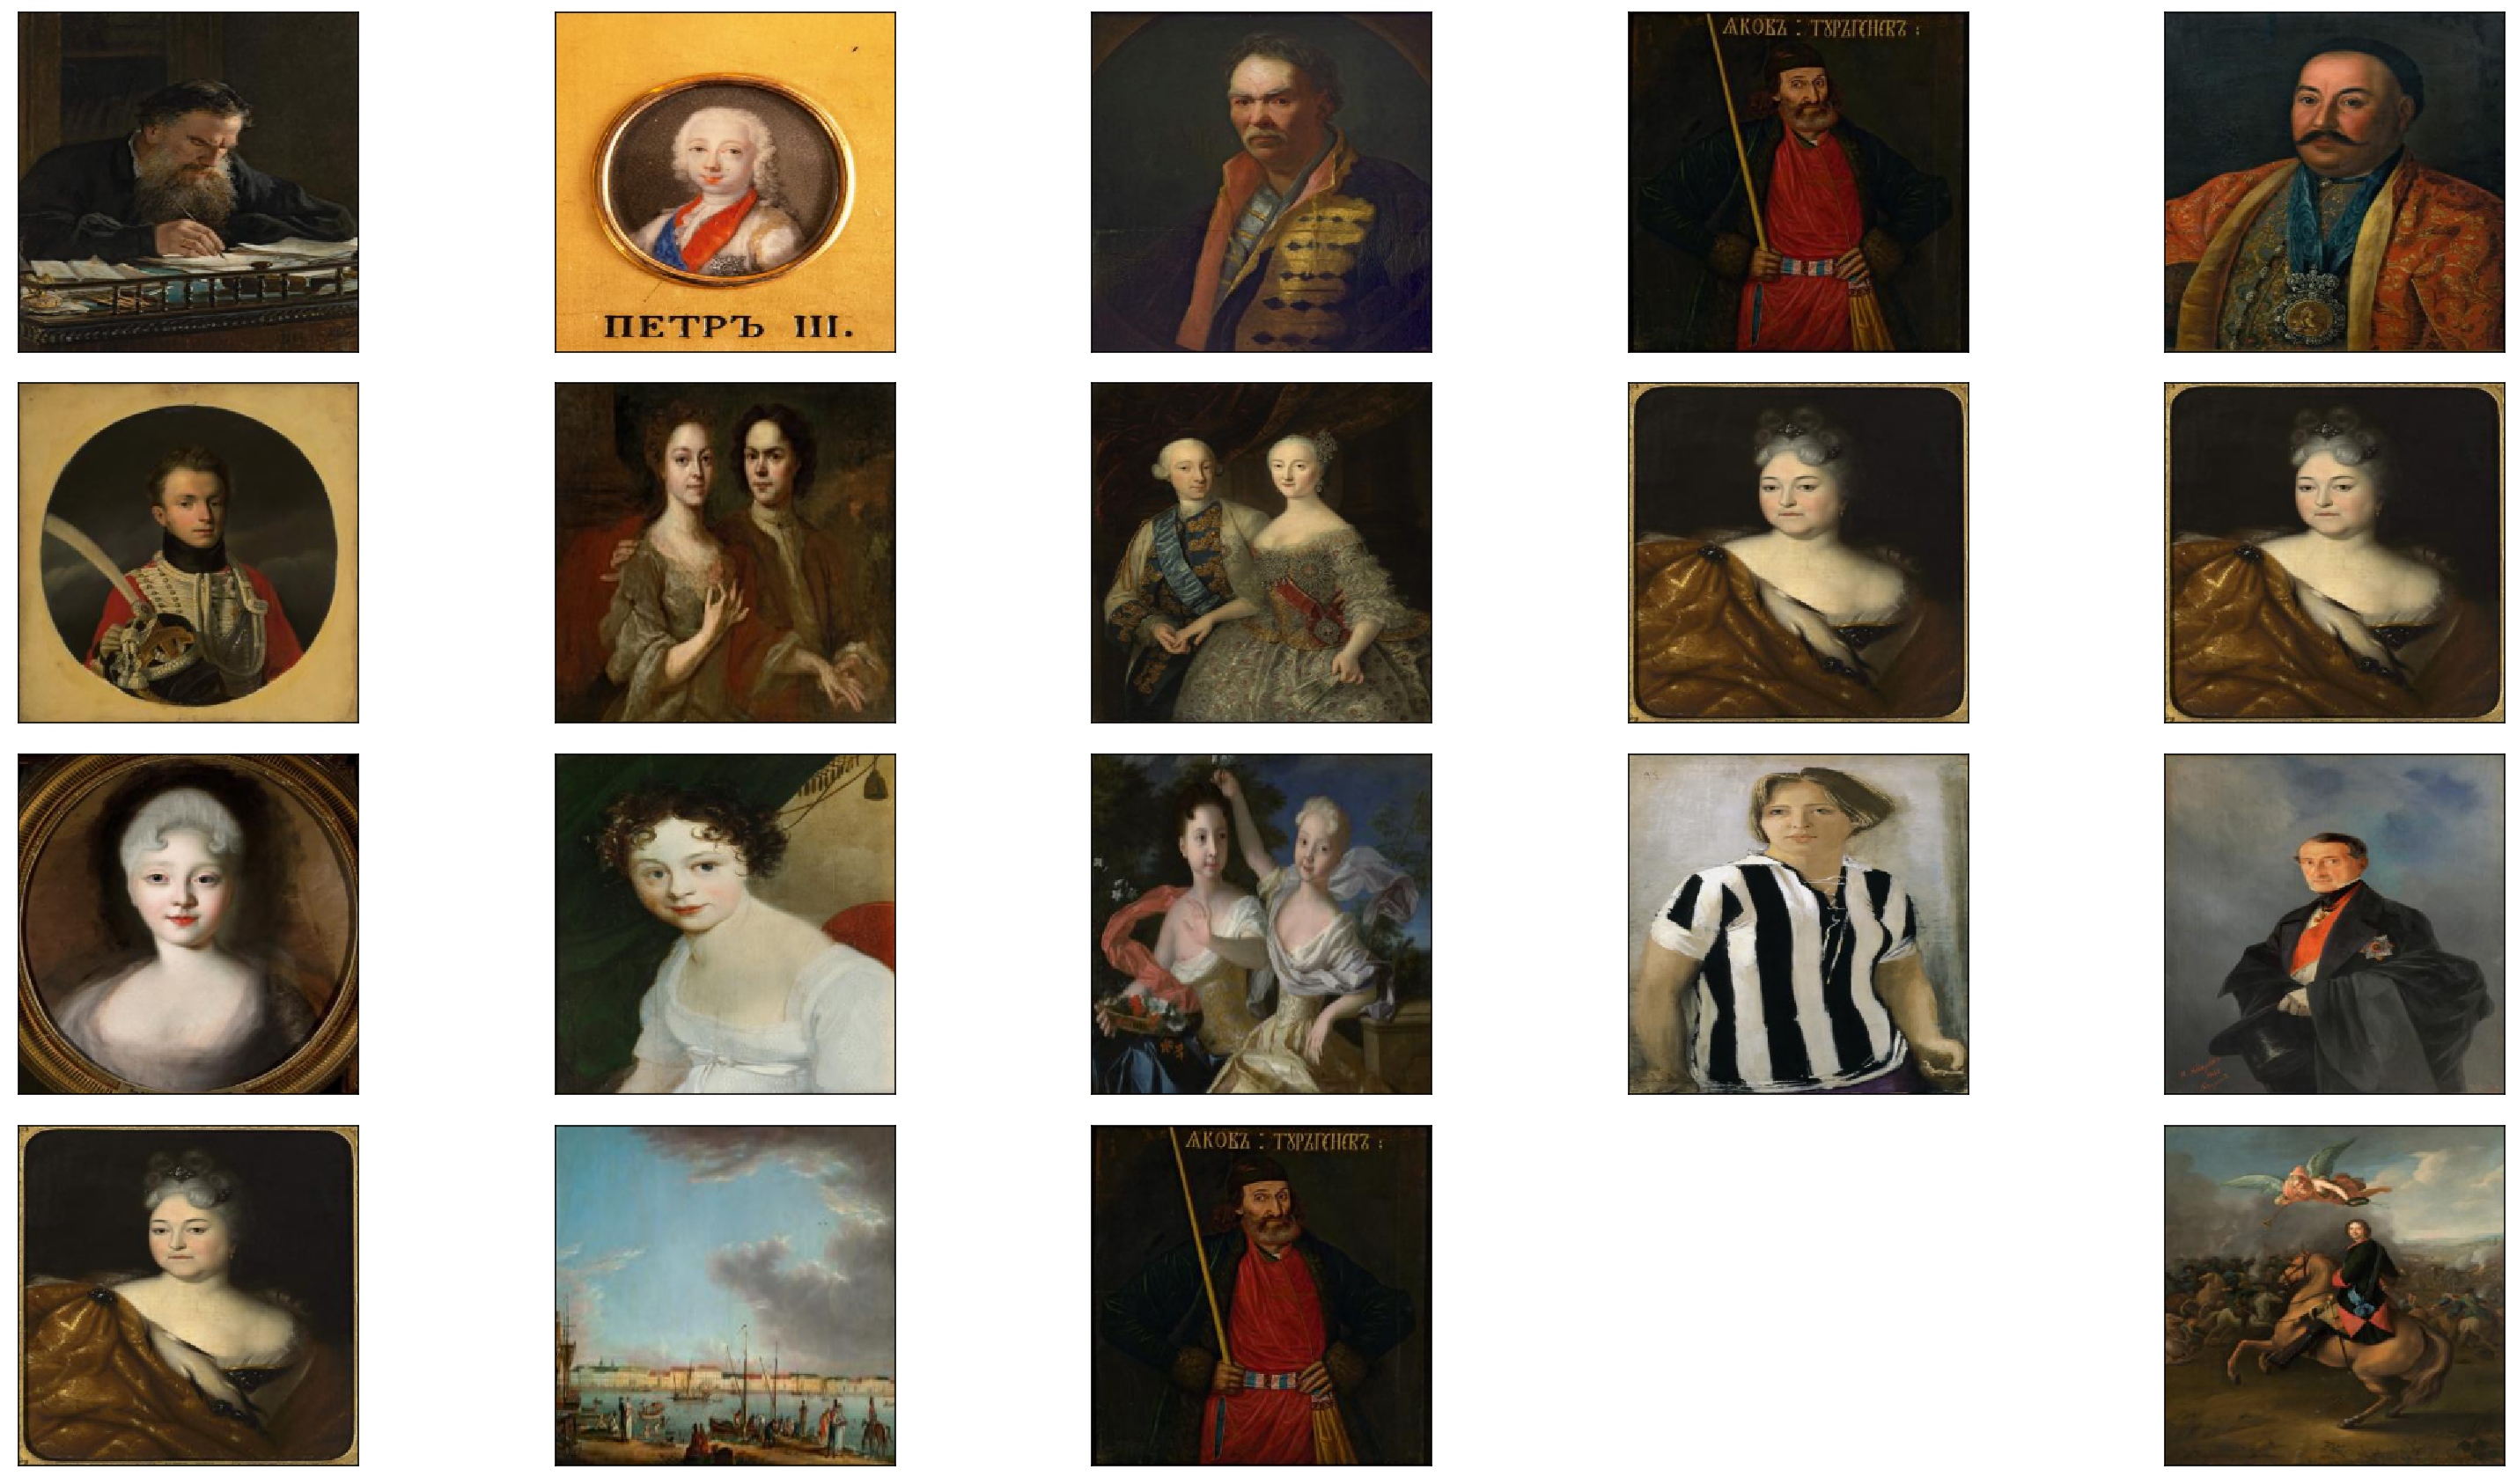

In [14]:
plt.figure(figsize=(22,12))
for i in range(20):
  plt.subplot(4,5,i+1)
  imshow(X_train[i])
  plt.xticks([])
  plt.yticks([])

In [0]:
X_train, X_test = train_test_split(X_train, test_size=20, random_state=2019)

### Create the model

In [17]:
def Colorize():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_423 (Conv2D)             (None, 256, 256, 128 1280        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 128 0           conv2d_423[0][0]                 
__________________________________________________________________________________________________
conv2d_424 (Conv2D)             (None, 128, 128, 128 262272      max_pooling2d_12[0][0]           
____________________________________________________________________________________________

In [0]:
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

### Data Generator Functions

In [13]:
%%time

# image transformer
datagen = ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 20,
    horizontal_flip = True
)

# create embedding
def create_inception_embedding(grayscaled_rgb):
  def resize_gray(x):
    return resize(x, (299,299,3), mode='constant')
  grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
  grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
  with inception.graph.as_default():
    embed = inception.predict(grayscaled_rgb_resized)
  return embed

# generate training data
def image_a_b_gen(dataset=X_train, batch_size = 20):
  for batch in datagen.flow(dataset, batch_size=batch_size):
      X_batch = rgb2gray(batch)
      grayscaled_rgb = gray2rgb(X_batch)
      lab_batch = rgb2lab(batch)
      X_batch = lab_batch[:,:,:,0]
      X_batch = X_batch.reshape(X_batch.shape+(1,))
      Y_batch = lab_batch[:,:,:,1:] / 128
      yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch

CPU times: user 467 µs, sys: 13 µs, total: 480 µs
Wall time: 492 µs


In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

file_path = 'Art_Colorization_Model.h5'
checkpoint = ModelCheckpoint(file_path,
                             save_best_only=True,
                             monitor='loss',
                             mode='min',
                             verbose=1)

early_stopping = EarlyStopping(monitor="loss", patience=3, verbose=1)

model_callbacks = [learning_rate_reduction, checkpoint, early_stopping]

In [21]:
%%time
BATCH_SIZE = 20
model_history = model.fit_generator(image_a_b_gen(X_train, BATCH_SIZE), epochs=30,
                    verbose=1, steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
                    callbacks=model_callbacks)



Epoch 1/30
101/101 [==============================] - 127s 1s/step - loss: 0.0149

Epoch 00001: loss improved from inf to 0.01490, saving model to Art_Colorization_Model.h5
Epoch 2/30
101/101 [==============================] - 102s 1s/step - loss: 0.0053

Epoch 00002: loss improved from 0.01490 to 0.00531, saving model to Art_Colorization_Model.h5
Epoch 3/30
101/101 [==============================] - 111s 1s/step - loss: 0.0049

Epoch 00003: loss improved from 0.00531 to 0.00488, saving model to Art_Colorization_Model.h5
Epoch 4/30
101/101 [==============================] - 111s 1s/step - loss: 0.0054

Epoch 00004: loss did not improve from 0.00488
Epoch 5/30
101/101 [==============================] - 111s 1s/step - loss: 0.0049

Epoch 00005: loss improved from 0.00488 to 0.00477, saving model to Art_Colorization_Model.h5
Epoch 6/30
101/101 [==============================] - 111s 1s/step - loss: 0.0046

Epoch 00006: loss improved from 0.00477 to 0.00461, saving model to Art_Colorizat

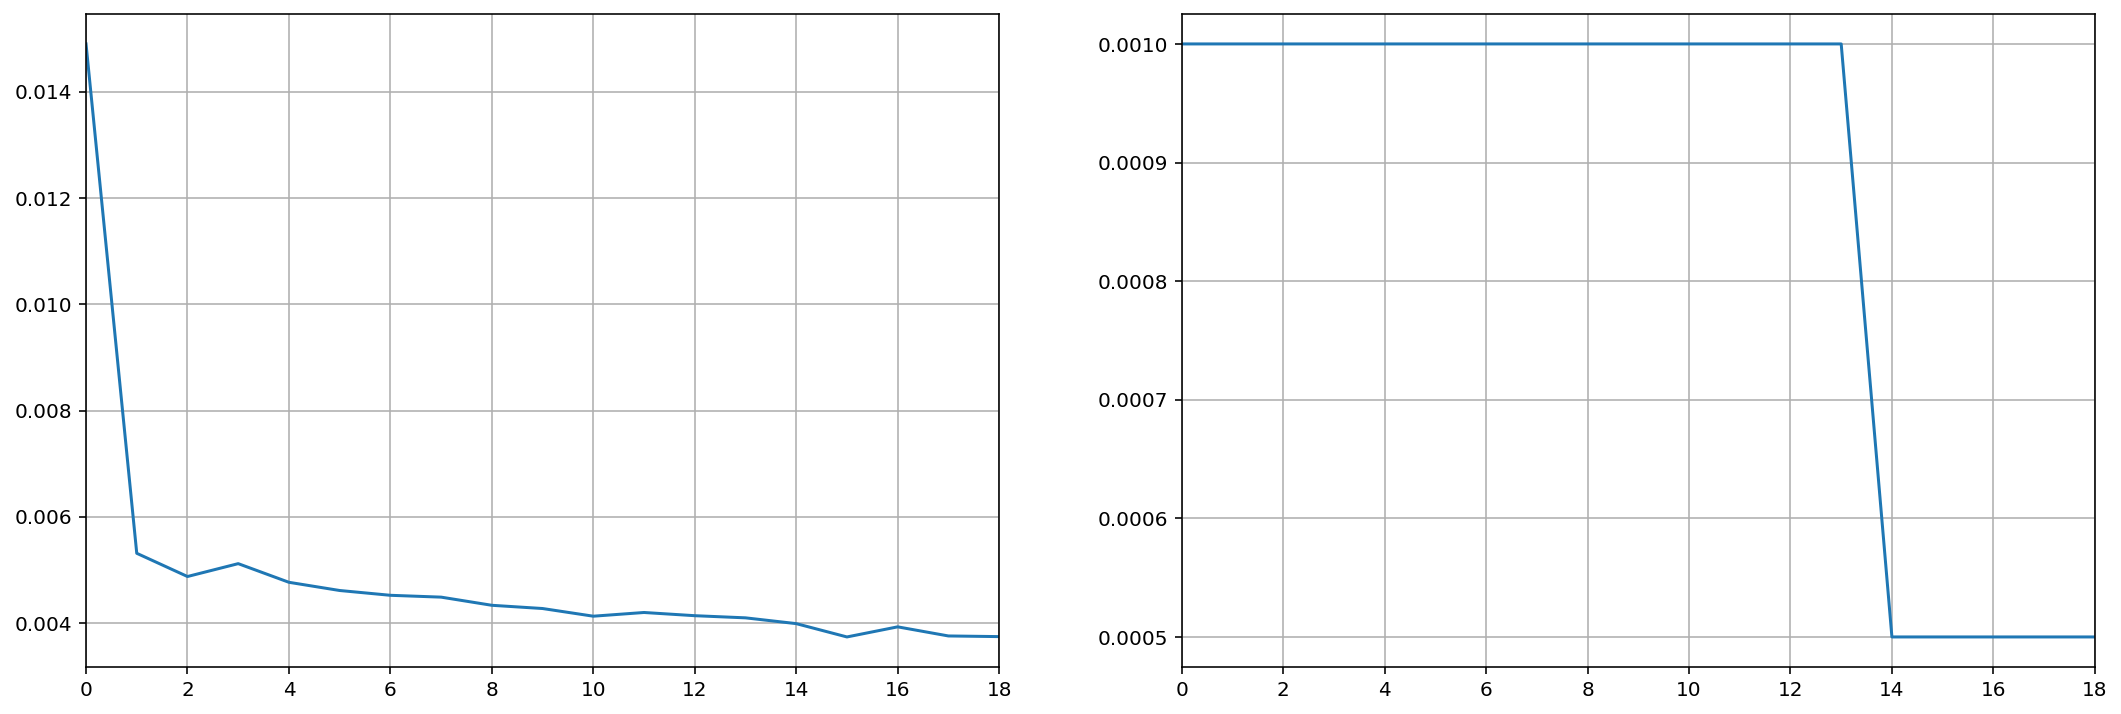

In [22]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
pd.DataFrame(model_history.history)["loss"].plot()
plt.grid(True)
plt.subplot(1,2,2)
pd.DataFrame(model_history.history)["lr"].plot()
plt.grid(True)

### Sample the results

In [0]:
sample = X_test 
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape + (1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_images = np.zeros((len(output), 256, 256, 3))
for i in range(len(output)):
  cur = np.zeros((256,256,3))
  cur[:,:,0] = color_me[i][:,:,0]
  cur[:,:,1:] = output[i]
  decoded_images[i] = lab2rgb(cur)
  cv2.imwrite("img_" + str(i) + ".jpg", lab2rgb(cur))

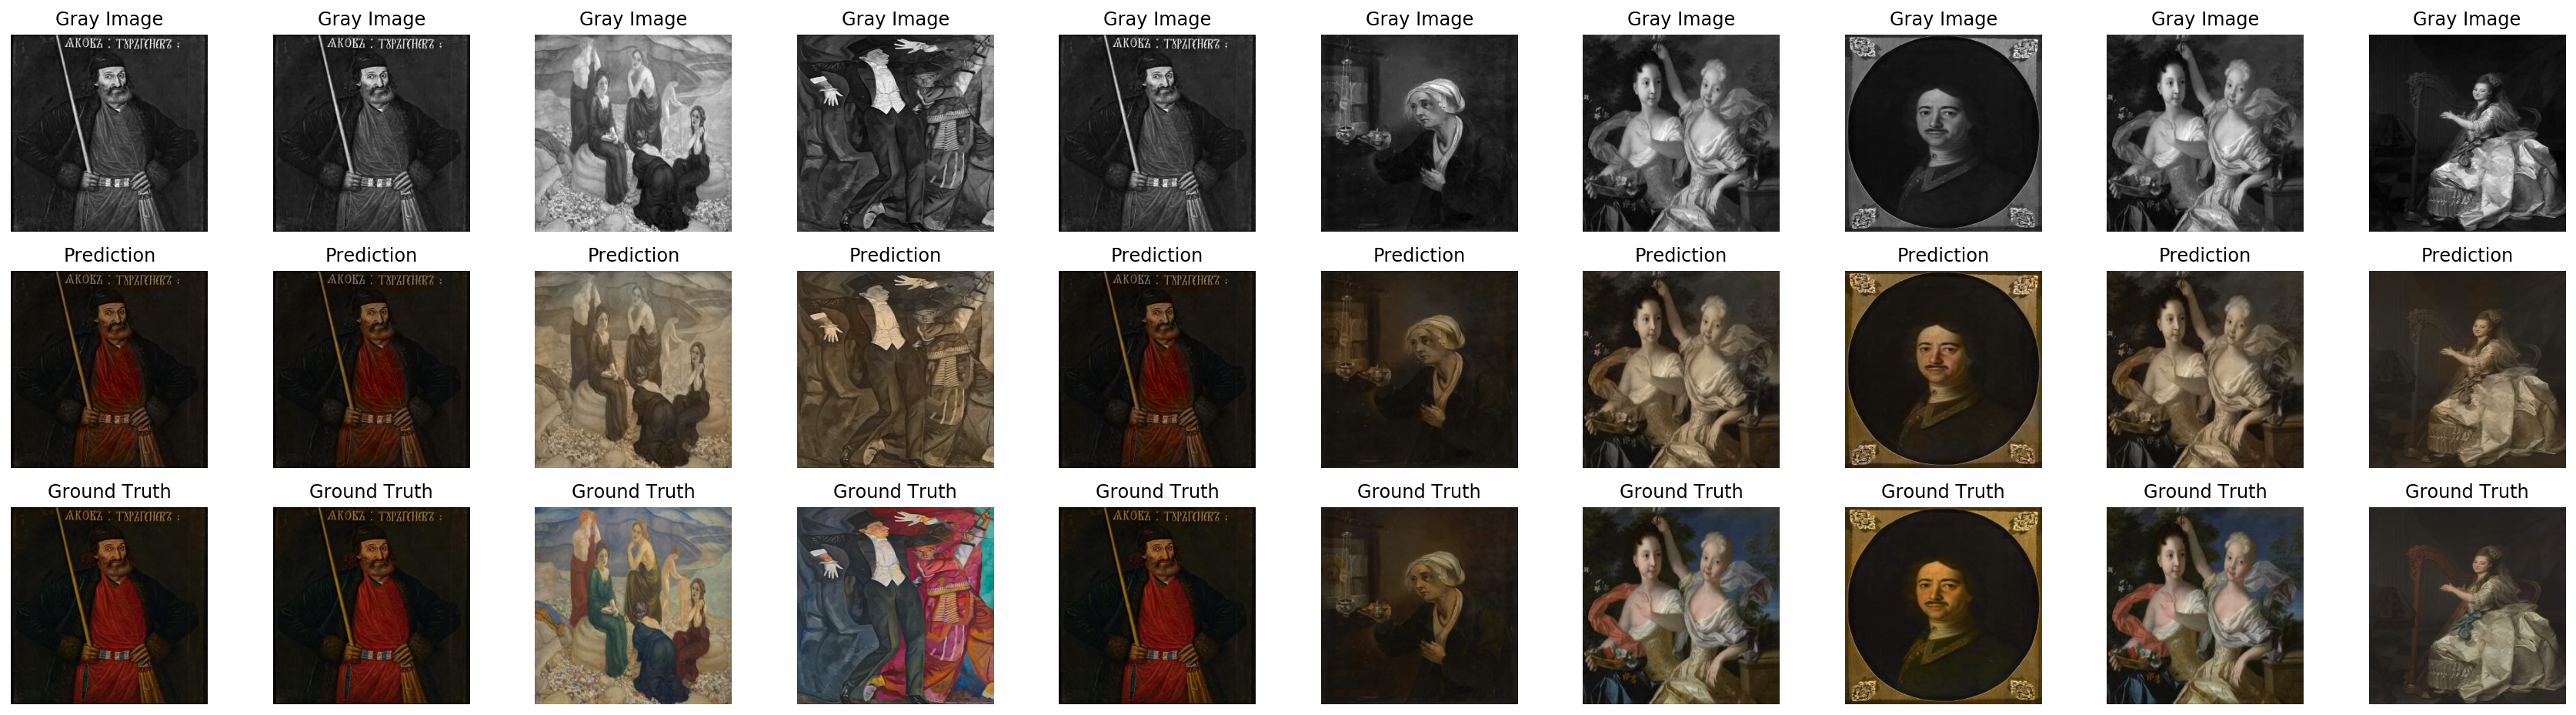

In [49]:
plt.figure(figsize=(30,8))
for i in range(10):
  plt.subplot(3,10,i+1)
  plt.imshow(rgb2gray(X_test)[i].reshape(256,256))
  plt.gray()
  plt.axis('off')
  plt.title("Gray Image")

  plt.subplot(3,10,i+1+10)
  plt.imshow(decoded_images[i].reshape(256, 256,3))
  plt.axis("off")
  plt.title("Prediction")

  plt.subplot(3,10,i+1+20)
  plt.imshow(X_test[i].reshape(256, 256,3))
  plt.axis("off")
  plt.title("Ground Truth")

### Santity Check

In [0]:
from keras.utils import get_file

In [0]:
model.load_weights('Art_Colorization_Model.h5')

(1, 256, 256, 3)


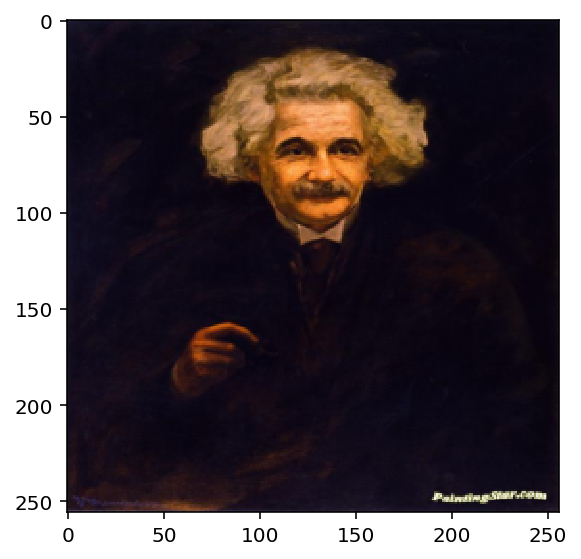

In [50]:
image_path2 = get_file("xyz","https://www.paintingstar.com/static/gallery/2005/07/22/52c280851a05b.jpg?Albert+Einstein+Artwork+by+Jean+Mannheim")
image = imread(image_path2)
image = image.astype('float32') / 255.
image = resize(image, (256,256))
imshow(image)
#image = ( image - image.mean() )/ image.std()
image = image[np.newaxis, ...]
print(image.shape)

In [0]:
color_me = gray2rgb(rgb2gray(image))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape + (1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_images = np.zeros((len(output), 256, 256, 3))
for i in range(len(output)):
  cur = np.zeros((256,256,3))
  cur[:,:,0] = color_me[i][:,:,0]
  cur[:,:,1:] = output[i]
  decoded_images[i] = lab2rgb(cur)
  cv2.imwrite("img_" + str(i) + ".jpg", lab2rgb(cur))

Text(0.5, 1.0, 'Ground Truth')

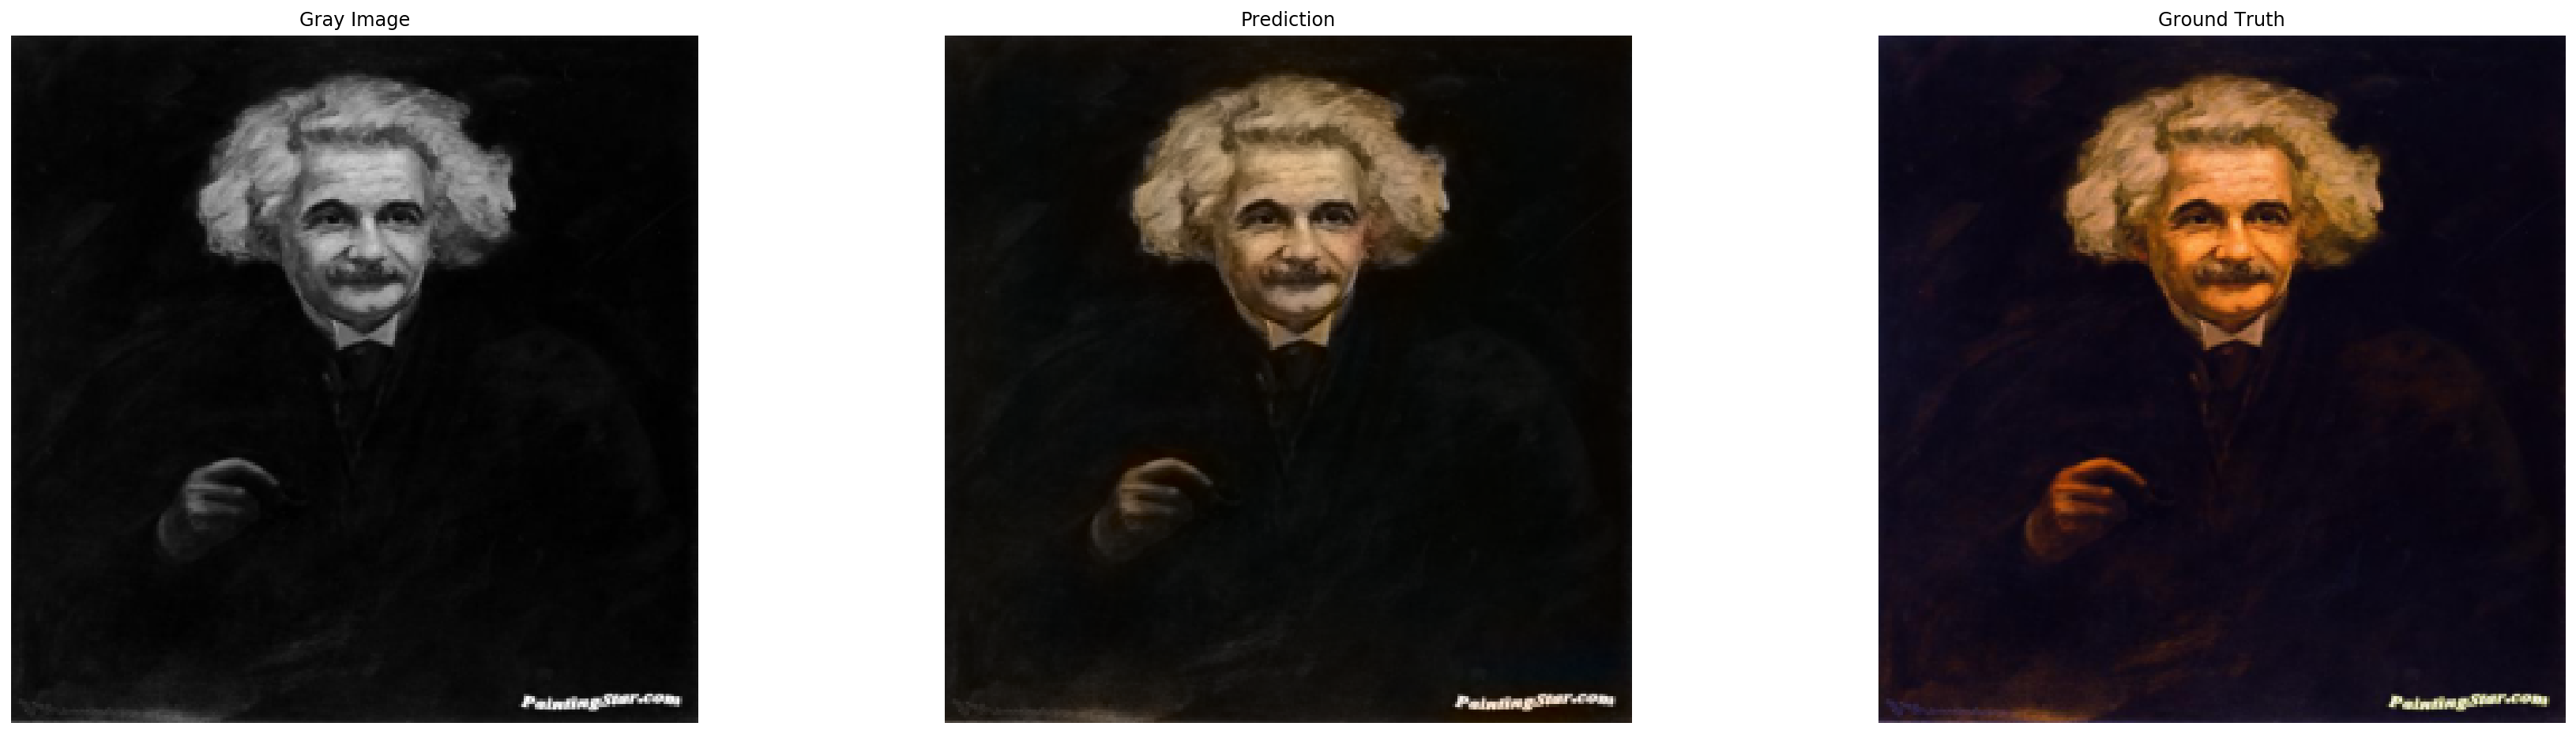

In [53]:
plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.imshow(rgb2gray(image)[0].reshape(256,256))
plt.gray()
plt.axis('off')
plt.title("Gray Image")

plt.subplot(1,3,2)
plt.imshow(decoded_images[0].reshape(256, 256,3))
plt.axis("off")
plt.title("Prediction")

plt.subplot(1,3,3)
plt.imshow(image[0].reshape(256, 256,3))
plt.axis("off")
plt.title("Ground Truth")

### Conclusion


The model is approximately able to identify the color of the image. Although it is brown-ish  but that's probably because of inconsistency of the dataset chosen. With better model and more data we can actually apply the same above techniques to generate fine colorized version of an b&w image.